<b> Submitted By</b>:<br>
<b>Name</b> : Shubham Dhull<br>
<b>Entry No. </b> 2017ceb1029
<br><b>Project Title</b> : Reservoir Inflow Predictions

<b>Introduction</b> :
<p> Reservoir inflow prediction is extremely important task that hydrologists have to encounter on day to day basis as its importance can't be overstressed. Wrong inflow prediction can lead to either floods or draughts which can result in loss of both life and property depending upon the magnitude of error made. It is also of paramount importance to know a range of inflows for design of the reservoir and structural health monitoring as well. If error is made, the whole reservoir could become unstable, can topple or crack resulting in drastic losses.</p><p>In this project, I try to build a comparative study of deep learning models such as LSTMs and other models such as support vector machines and random forest regressors. The best model can then be chosen to replace the convetional methods of doing such predictions.</p>

<b>Methodology</b>:<br>
I first began by analyzing the data by inspecting the data by plotting it. The data I have used is courtesy of Bhakra Beas Managment Board (BBMB), the governing body responsible for the administration of bhakra dam. The data consists of daily inflows in the reservoir for 2485 days.<p>Then I made the time series into a supervised form of data by shifting the original data by one day(10 days in case of LSTM) and making it the target data, I also normalized the data for better performance of the model by using the minimax scalar, this comprises the preprocessing of the provided time series<p>After this I trained three different models by experimenting on the various parameters and comparing the best possible configuration of the respective models.The metric for comparision was the RMS loss on the test data.

<b> Related work :</b><br>
I have referred to the following research papers for my project:<br>1.) Stream-Flow Forecasting of Small Rivers Based on
LSTM, Youchuan Huet al 
<br>2.) Rainfall-Runoff modelling using Long-Short-Term-Memory
(LSTM) networks, Frederik Kratzert et al.



In [0]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler


Using TensorFlow backend.


In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving data_inflows.csv to data_inflows.csv
User uploaded file "data_inflows.csv" with length 58528 bytes


<bound method NDFrame.head of Date and Time
15/06-2013 06 AM    48220
16/06-2013 06 AM    55917
17/06-2013 06 AM    46580
18/06-2013 06 AM    55262
19/06-2013 06 AM    46232
                    ...  
10/04-2020 06 AM     8942
11/04-2020 06 AM     9109
12/04-2020 06 AM     9110
13/04-2020 06 AM     9504
14/04-2020 06 AM    10666
Name: Inflows in cu-ft/sec, Length: 2485, dtype: int64>


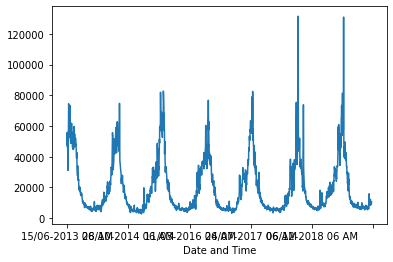

In [0]:
dataframe = pandas.read_csv('data_inflows.csv', header=0, index_col=0)
print(dataframe.head)
dataframe.plot()
plt.show()
#here I have plotted how the data looks w.r.t the time, we can already see the sequential nature of the inflows
df=pandas.DataFrame(dataframe)
time_series = df["Inflows in cu-ft/sec"].values
time_series=time_series.astype('float32')

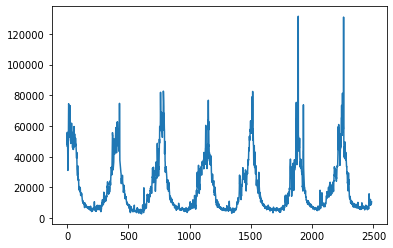

In [0]:
plt.plot(time_series) #now we have extracted the values and no longer care about the time but only the relative ordering of the inflows

In [0]:
time_series =  time_series.reshape(-1,1)

In [0]:
time_series.ndim

2

In [0]:

scaler  = MinMaxScaler(feature_range=(0, 1))  #using the minimax scaler to normalize the data
time_series = scaler.fit_transform(time_series)

In [0]:
print(time_series[0:2,0])

[0.3531226  0.41291764]


In [0]:
#taking a 2:1 train-test split to train the model
train_size  = int(len(time_series) * 0.67)
test_size   = len(time_series) - train_size
train, test = time_series[0:train_size], time_series[train_size:len(time_series)]
print("Train length is: ",len(train),"\n \n" ,"Test length is ",len(test))

Train length is:  1664 
 
 Test length is  821


Training Data is plotted below


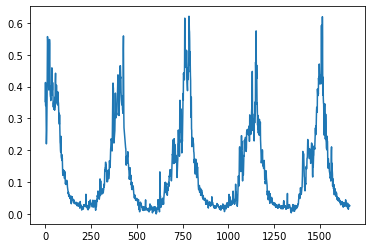

Test data is plotted below


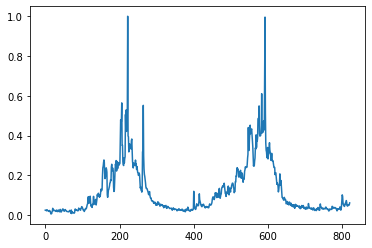

In [0]:
print("Training Data is plotted below")
plt.plot(train)
plt.show()
print("Test data is plotted below")
plt.plot(test)
plt.show()

In [0]:
trainX, trainY = [] , [] ##Here, I am just shifting the values down to create a supervised data, 
#here we are using the remembering propeties of LSTMs from the past 10 days(it is generally considered limit of lstms as per RP.2 )
for i in range(len(train)-11):
        temp = train[i:(i+10),0]
        trainX.append(temp)
        trainY.append(train[i + 10,0])
trainX=np.array(trainX)
trainY=np.array(trainY)
testX, testY   = [] , []
i=0
for i in range(len(test)-11):
        temp = test[i:(i+10),0]
        testX.append(temp)
        testY.append(test[i + 10,0])
testX=np.array(testX)
testY=np.array(testY)

In [0]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#I have to reshape it in the format Samples/TimeSteps/Features format

<b>Let me use this space to describe theory relating the LSTM cell and my experiments with it : </b><br>
<br>units :	Positive integer, dimensionality of the output space.  
(I checked for 2,4,6 and 8)<br>
<p>activation : 	Activation function to use. Default: hyperbolic tangent (tanh); If none is passed, it uses only the linear which I didn't want and after reading tanh seemed fine. </p>
<p>use_bias :	Boolean (default True), I used the bias vector as is generally better.</p>
<p>kernel_initializer:	Initializer for the kernel weights matrix, used for the linear transformation of the inputs. Default: glorot_uniform.</p>
<p>recurrent_initializer:	Initializer for the recurrent_kernel weights matrix, used for the linear transformation of the recurrent state. Default: orthogonal.
<p>bias_initializer:	Initializer for the bias vector. Default: zeros.
<p>unit_forget_bias:	Boolean (default True). If True, add 1 to the bias of the forget gate at initialization. Setting it to true will also force bias_initializer="zeros". This is recommended in Jozefowicz et al..(<b>Referred: An Empirical Exploration of Recurrent Network Architectures </b>)
<p>kernel_regularizer	: Regularizer function applied to the kernel weights matrix. Default: None.
<p>recurrent_regularizer:	Regularizer function applied to the recurrent_kernel weights matrix. Default: None.
<p>bias_regularizer:	Regularizer function applied to the bias vector. Default: None.
<p>activity_regularizer:	Regularizer function applied to the output of the layer (its "activation"). Default: None.
<p>kernel_constraint:	Constraint function applied to the kernel weights matrix. Default: None.
<p>recurrent_constraint:	Constraint function applied to the recurrent_kernel weights matrix. Default: None.
<p>bias_constraint:	Constraint function applied to the bias vector. Default: None.
<p>dropout:	Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs. Default: 0 (I used 0.1, 0.01 performed worse both cases ).
<p>recurrent_dropout:	Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state. Default: 0.
<p>implementation:	Implementation mode, either 1 or 2. Mode 1 structures its operations as a larger number of smaller dot products and additions, whereas mode 2 will batch them into fewer, larger operations. These modes will have different performance profiles on different hardware and for different applications. Default: 2.
<p>return_sequences:	Boolean. Whether to return the last output. in the output sequence, or the full sequence. Default: False.
<p>return_state:	Boolean. Whether to return the last state in addition to the output. Default: False.
<p>go_backwards:	Boolean (default False). If True, process the input sequence backwards and return the reversed sequence.(No sequence was to be returned)
<p>stateful:	Boolean (default False). If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
<p>time_major:	The shape format of the inputs and outputs tensors. If True, the inputs and outputs will be in shape [timesteps, batch, feature], whereas in the False case, it will be [batch, timesteps, feature].Used default False as data is batch major.
<p>unroll:	Boolean (default False). If True, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up a RNN, although it tends to be more memory-intensive. Used default only.

In [0]:
def moddel_LSTM(units_co, dropout_co, K_i= 'glorot_uniform'):
  model = Sequential()
  model.add(LSTM(units=units_co, dropout = dropout_co, kernel_initializer=K_i, input_dim=10))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model
  

In [0]:
units_list = [2,4,6,8]
train_errorrs = []

for unit in units_list:
  model_check = moddel_LSTM(units_co= unit, dropout_co=0) #checking which unit does best
  model_check.fit(trainX, trainY, nb_epoch=50, batch_size=1, verbose=2) #Ichecked that the loss hardly changes after some 50 epochs hence 50 seems enough
  train_error = model_check.evaluate(trainX, trainY, verbose=2)
  print('The train error is: %.5f in RMS terms' % (train_error), " for model number ", units_list.index(unit)+1) #in RMS as described above.
  train_errorrs.append(train_error)

best_unit = train_errorrs.index(min(train_errorrs))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/50
 - 2s - loss: 0.0081
Epoch 2/50
 - 2s - loss: 0.0036
Epoch 3/50
 - 2s - loss: 0.0034
Epoch 4/50
 - 2s - loss: 0.0039
Epoch 5/50
 - 2s - loss: 0.0036
Epoch 6/50
 - 2s - loss: 0.0038
Epoch 7/50
 - 2s - loss: 0.0041
Epoch 8/50
 - 2s - loss: 0.0034
Epoch 9/50
 - 2s - loss: 0.0040
Epoch 10/50
 - 2s - loss: 0.0041
Epoch 11/50
 - 2s - loss: 0.0037
Epoch 12/50
 - 2s - loss: 0.0044
Epoch 13/50
 - 2s - loss: 0.0037
Epoch 14/50
 - 2s - loss: 0.0036
Epoch 15/50
 - 2s - loss: 0.0040
Epoch 16/50
 - 2s - loss: 0.0034
Epoch 17/50
 - 2s - loss: 0.0037
Epoch 18/50
 - 2s - loss: 0.0034
Epoch 19/50
 - 2s - loss: 0.0037
Epoch 20/50
 - 2s - loss: 0.0035
Epoch 21/50
 - 2s - loss: 0.0035
Epoch 22/50
 - 2s - loss: 0.0032
Epoch 23/50
 - 2s - loss: 0.0035
Epoch 24/50
 - 2s - loss: 0.0044
Epoch 25/50
 - 2s - loss: 0.0042
Epoch 26/50
 - 2s - loss: 0.0033
Epoch 27/50
 - 2s - loss: 0.0042
Epoch 28/50
 - 2s - loss: 0.0043
Epoch 29/50
 - 2s - loss: 0.0040
Epoch 30/50
 - 2s - loss: 0.0030
Epoch 31/50
 - 2s -

In [0]:
best_unit= units_list[best_unit]
print("Best unit which should be taken is ",best_unit)

Best unit which should be taken is  8


In [0]:
#let us first determine best droput probability for one set of units
train_errorrs= []
dropout_probs = [0,0.001,0.01,0.1]
for prob in dropout_probs:
  model_check = moddel_LSTM(units_co = best_unit, dropout_co = prob)
  model_check.fit(trainX,trainY,nb_epoch=50, batch_size=1, verbose=2)
  train_error = model_check.evaluate(trainX, trainY, verbose=2)
  print('The train error is: %.5f in RMS terms' % (train_error), " for model number ", dropout_probs.index(prob)+1) #in RMS as described above.
  train_errorrs.append(train_error)

best_prob = train_errorrs.index(min(train_errorrs))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/50
 - 2s - loss: 0.0091
Epoch 2/50
 - 2s - loss: 0.0031
Epoch 3/50
 - 2s - loss: 0.0037
Epoch 4/50
 - 2s - loss: 0.0042
Epoch 5/50
 - 2s - loss: 0.0033
Epoch 6/50
 - 2s - loss: 0.0044
Epoch 7/50
 - 2s - loss: 0.0034
Epoch 8/50
 - 2s - loss: 0.0037
Epoch 9/50
 - 2s - loss: 0.0038
Epoch 10/50
 - 2s - loss: 0.0037
Epoch 11/50
 - 2s - loss: 0.0027
Epoch 12/50
 - 2s - loss: 0.0033
Epoch 13/50
 - 2s - loss: 0.0035
Epoch 14/50
 - 2s - loss: 0.0033
Epoch 15/50
 - 2s - loss: 0.0037
Epoch 16/50
 - 2s - loss: 0.0036
Epoch 17/50
 - 2s - loss: 0.0033
Epoch 18/50
 - 2s - loss: 0.0038
Epoch 19/50
 - 2s - loss: 0.0033
Epoch 20/50
 - 2s - loss: 0.0044
Epoch 21/50
 - 2s - loss: 0.0038
Epoch 22/50
 - 2s - loss: 0.0038
Epoch 23/50
 - 2s - loss: 0.0052
Epoch 24/50
 - 2s - loss: 0.0035
Epoch 25/50
 - 2s - loss: 0.0041
Epoch 26/50
 - 2s - loss: 0.0045
Epoch 27/50
 - 2s - loss: 0.0034
Epoch 28/50
 - 2s - loss: 0.0036
Epoch 29/50
 - 2s - loss: 0.0044
Epoch 30/50
 - 2s - loss: 0.0036
Epoch 31/50
 - 2s -

In [0]:
best_prob = dropout_probs[best_prob]
print("The best probability to be used for model is ", best_prob)

The best probability to be used for model is  0.001


In [0]:
#let us check the initialization as well because i have seen that it causes huge change as well
train_errorrs = []
intiser = [ 'uniform', 'glorot_uniform', 'normal']
for ini in intiser:
  model_check = moddel_LSTM(units_co = best_unit, dropout_co = best_prob, K_i = ini)
  model_check.fit(trainX,trainY,nb_epoch=50, batch_size=1, verbose=2)
  train_error = model_check.evaluate(trainX, trainY, verbose=2)
  print('The train error is: %.5f in RMS terms' % (train_error), " for model number ", intiser.index(ini)+1) #in RMS as described above.
  train_errorrs.append(train_error)

best_distribution = train_errorrs.index(min(train_errorrs))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Epoch 1/50
 - 2s - loss: 0.0097
Epoch 2/50
 - 2s - loss: 0.0039
Epoch 3/50
 - 2s - loss: 0.0036
Epoch 4/50
 - 2s - loss: 0.0038
Epoch 5/50
 - 2s - loss: 0.0032
Epoch 6/50
 - 2s - loss: 0.0036
Epoch 7/50
 - 2s - loss: 0.0037
Epoch 8/50
 - 2s - loss: 0.0036
Epoch 9/50
 - 2s - loss: 0.0043
Epoch 10/50
 - 2s - loss: 0.0047
Epoch 11/50
 - 2s - loss: 0.0037
Epoch 12/50
 - 2s - loss: 0.0040
Epoch 13/50
 - 2s - loss: 0.0038
Epoch 14/50
 - 2s - loss: 0.0037
Epoch 15/50
 - 2s - loss: 0.0041
Epoch 16/50
 - 2s - loss: 0.0035
Epoch 17/50
 - 2s - loss: 0.0028
Epoch 18/50
 - 2s - loss: 0.0043
Epoch 19/50
 - 2s - loss: 0.0035
Epoch 20/50
 - 2s - loss: 0.0038
Epoch 21/50
 - 2s - loss: 0.0043
Epoch 22/50
 - 2s - loss: 0.0042
Epoch 23/50
 - 2s - loss: 0.0046
Epoch 24/50
 - 2s - loss: 0.0029
Epoch 25/50
 - 2s - loss: 0.0032
Epoch 26/50
 - 2s - loss: 0.0032
Epoch 27/50
 - 2s - loss: 0.0044
Epoch 28/50
 - 2s - loss: 0.0043
Epoch 29/50
 - 2s - loss: 0.0034
Epoch 30/50
 - 2s - loss: 0.0030
Epoch 31/50
 - 2s -

In [0]:
best_distribution = intiser[best_distribution]
print("The best distribution to be used for optimum model is ", best_distribution)
#Surely the loss decreases but the initial value of loss depends on the initial distribution.

The best distribution to be used for optimum model is  uniform


In [0]:
#Finally, let's test with all the best possible configuration
Model = moddel_LSTM(units_co = best_unit , dropout_co = best_prob, K_i = best_distribution)
#let's check the best train rms error 
Model.fit(trainX,trainY,nb_epoch=50, batch_size=1, verbose=2)
train_error = Model.evaluate(trainX, trainY, verbose=2)
print('The train error is: %.5f in RMS terms' % (train_error), "on the optimum model vis-a-vis the parameters") 
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Epoch 1/50
 - 2s - loss: 0.0112
Epoch 2/50
 - 2s - loss: 0.0036
Epoch 3/50
 - 2s - loss: 0.0035
Epoch 4/50
 - 2s - loss: 0.0036
Epoch 5/50
 - 2s - loss: 0.0033
Epoch 6/50
 - 2s - loss: 0.0045
Epoch 7/50
 - 2s - loss: 0.0034
Epoch 8/50
 - 2s - loss: 0.0037
Epoch 9/50
 - 2s - loss: 0.0034
Epoch 10/50
 - 2s - loss: 0.0042
Epoch 11/50
 - 2s - loss: 0.0040
Epoch 12/50
 - 2s - loss: 0.0036
Epoch 13/50
 - 2s - loss: 0.0040
Epoch 14/50
 - 2s - loss: 0.0033
Epoch 15/50
 - 2s - loss: 0.0037
Epoch 16/50
 - 2s - loss: 0.0032
Epoch 17/50
 - 2s - loss: 0.0042
Epoch 18/50
 - 2s - loss: 0.0035
Epoch 19/50
 - 2s - loss: 0.0039
Epoch 20/50
 - 2s - loss: 0.0037
Epoch 21/50
 - 2s - loss: 0.0033
Epoch 22/50
 - 2s - loss: 0.0047
Epoch 23/50
 - 2s - loss: 0.0038
Epoch 24/50
 - 2s - loss: 0.0040
Epoch 25/50
 - 2s - loss: 0.0039
Epoch 26/50
 - 2s - loss: 0.0036
Epoch 27/50
 - 2s - loss: 0.0043
Epoch 28/50
 - 2s - loss: 0.0042
Epoch 29/50
 - 2s - loss: 0.0031
Epoch 30/50
 - 2s - loss: 0.0038
Epoch 31/50
 - 2s -

In [0]:

##let us check on the test data now : 
test_error = Model.evaluate(testX,testY,verbose=2)
print("The test error is: %.5f in RMS terms" %(test_error))

The test error is: 0.00278 in RMS terms


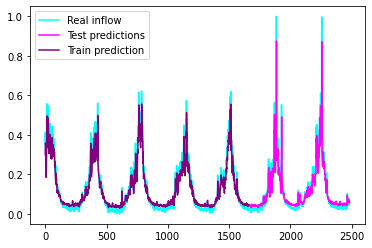

Since the overlap is much, plotting differently
-----------Real values-----------


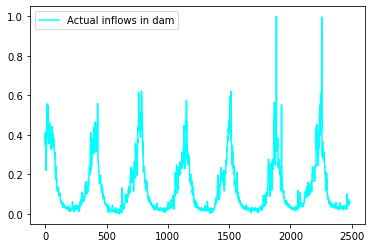

-----------Predicted-----------


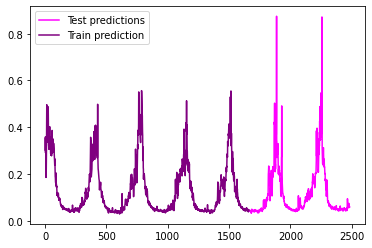

In [0]:

predict_train = model.predict(trainX)
predict_test  = model.predict(testX)
 
# shift train predictions for plotting
train_plot       = np.empty_like(time_series)
train_plot[:, :] = np.nan
train_plot[10:len(predict_train)+10, :] = predict_train
 
# shift test predictions for plotting
test_plot       = np.empty_like(time_series)
test_plot[:, :] = np.nan
test_plot[len(predict_train)+21:len(time_series)-1, :] = predict_test

plt.plot(time_series, color= 'cyan', label = 'Real inflow')
plt.plot(test_plot, color='magenta', label = 'Test predictions' )
plt.plot(train_plot, color = 'purple' , label = 'Train prediction' )
plt.legend(loc= 'best')
plt.show()
print("Since the overlap is much, plotting differently")
print("-----------Real values-----------")
plt.plot(time_series, color = 'cyan', label = 'Actual inflows in dam')
plt.legend(loc= 'best')
plt.show()
print("-----------Predicted-----------")
plt.plot(test_plot, color='magenta', label = 'Test predictions' )
plt.plot(train_plot, color = 'purple' , label = 'Train prediction' )
plt.legend(loc= 'best')
plt.show()

I can see that the model is doing excellently through visual inspection as well as the extremely low values of the RMS error. But, although the model is able to learn the series correctly, it is underestimating the flood peaks when they are extreme. When the peaks are not extreme i.e on the train set, the model is correctly able to predict, in case of test predictions(blue ones) the model is able to forcast the relative changes correctly but underestimates the flood as it assumes that similar trend will be followed. Therefore, this model can be adopted to forcast the inflows to considerable accuracy.

Now Let us try too use another powerful moel which can be used for time series analysis i.e. Support Vector Machines(SVM), again it can be done in a similar fashion as the previous lstm model.

In [0]:
dataframe = pandas.read_csv('data_inflows.csv', header=0, index_col=0, squeeze=True)
#here I am using the same dataset, so no neeed to plot again
df=pandas.DataFrame(dataframe)
series = df["Inflows in cu-ft/sec"].values
series=series.astype('float32')
print(series)

[48220. 55917. 46580. ...  9110.  9504. 10666.]


In [0]:
train_len = (int)(0.67*len(series)) #2/3 for training
test_len = len(series) - train_len
train, test = series[0:train_len] , series[train_len:len(series)]
print(train_len,test_len)

1664 821


In [0]:
trainx, trainy = [0], [] #this time only 1 is shifted as there is no remembrance property
for x in range(train_len):
  trainx.append(train[x]) 
  trainy.append(train[x])
trainy.append(0)
print(trainx[0:3], trainy[0:3])
#similarly for test data
testx, testy = [0], []
for x in range(test_len):
  testx.append(test[x])
  testy.append(test[x])
testy.append(0)
print(testx[0:3], testy[0:3])

[0, 48220.0, 55917.0] [48220.0, 55917.0, 46580.0]
[0, 5962.0, 5931.0] [5962.0, 5931.0, 6013.0]


In [0]:
trainx = np.asarray(trainx, dtype = 'float32') #as these were lists, made array so that np can be used 
testx = np.asarray(testx, dtype = 'float32')
trainy = np.asarray(trainy, dtype = 'float32')
testy = np.asarray(testy, dtype = 'float32')

trainx = trainx.reshape(-1,1)
testx = testx.reshape(-1,1)
trainy = trainy.reshape(-1,1)
testy = testy.reshape(-1,1)

scaler  = MinMaxScaler(feature_range=(0, 1)) 
trainx = scaler.fit_transform(trainx)
testx = scaler.fit_transform(testx)
trainy = scaler.fit_transform(trainy)
testy = scaler.fit_transform(testy)

testy = np.ravel(testy)
trainy = np.ravel(trainy)


In [0]:
print(trainx[0:3], np.ravel(trainy[0:3]))

[[0.        ]
 [0.5829585 ]
 [0.67601186]] [0.5829585  0.67601186 0.5631317 ]


<b> These are the various parameters of the SVR in scikit learn, here I explain about the hyperparameter tweaking that I did</b>: 

<p>kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used. I checked for different kernels and chose the best one among them, which turned out to be rbf actually.

<p>degree : int, default=3
Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
I did test the polynomial kernel as I tested it separately and was performing on par with linear kernel i.e degree = 1 performed the best. I have not explicitly shown it here.

<p>C : float, default=1.0
Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty. I tried different values of this varying in powers of 10.

<p>verbose : bool, default=False
Enable verbose output. Note that this setting takes advantage of a per-process runtime setting in libsvm that, if enabled, may not work properly in a multithreaded context.

max_iter : int, default=-1
Hard limit on iterations within solver, or -1 for no limit. was not needed to check.



The rms error found in this case is 0.05715016276952181
Plot for linear  as kernel


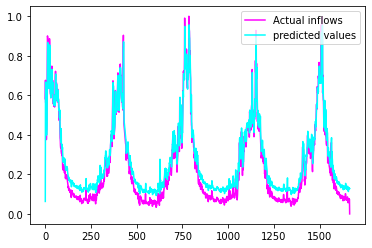

The rms error found in this case is 0.045684779391797034
Plot for rbf  as kernel


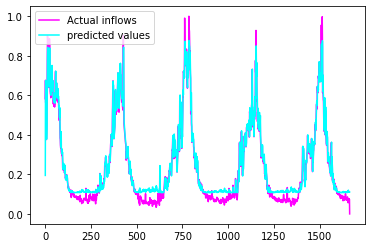

The rms error found in this case is 98.51753335493332
Plot for sigmoid  as kernel


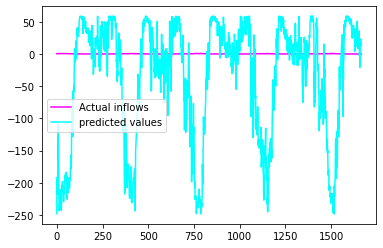

The best kernel to be used is rbf


In [0]:
kernels = ['linear','rbf','sigmoid'] #choosing the best kernel as it is crux of svm
train_errors = []
from sklearn.svm import SVR
from math import sqrt
from sklearn.metrics import mean_squared_error
for ker_nel in kernels:
  svr = SVR(kernel = ker_nel) # will test C later
  svr = svr.fit(trainx,trainy)
  predicted_train = svr.predict(trainx)
  rms = sqrt(mean_squared_error(trainy, predicted_train))
  train_errors.append(rms)
  print("The rms error found in this case is",rms)
  print("Plot for", ker_nel," as kernel")
  plt.plot(trainy,color = 'magenta', label = 'Actual inflows')
  plt.plot(predicted_train,color = 'cyan' , label = 'predicted values')
  plt.legend(loc ='best')
  plt.show()
best_kernel = kernels[(train_errors.index(min(train_errors)))]
print("The best kernel to be used is",best_kernel)

The rms error found in this case is 0.05364547301465907
Plot for C as 0.1


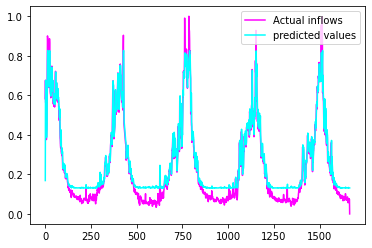

The rms error found in this case is 0.045684779391797034
Plot for C as 1


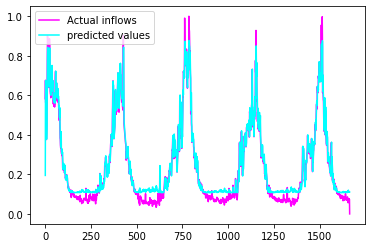

The rms error found in this case is 0.04259082562770733
Plot for C as 10


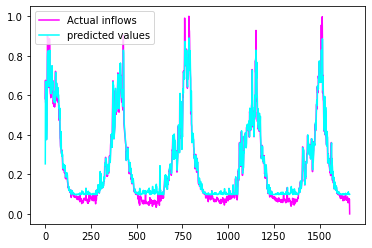

The rms error found in this case is 0.04435012632164786
Plot for C as 100


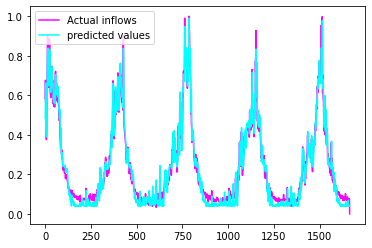

The best regularization constant is  10


In [0]:
#let us do a similar analysis for values of C(the regularization constant)
train_errors = []
C= [0.1,1,10,100]
for c in C:
  svr = SVR(kernel = best_kernel, C= c) # will test C later
  svr = svr.fit(trainx,trainy)
  predicted_train = svr.predict(trainx)
  rms = sqrt(mean_squared_error(trainy, predicted_train))
  train_errors.append(rms)
  print("The rms error found in this case is",rms)
  print("Plot for C as",c)
  plt.plot(trainy,color = 'magenta', label = 'Actual inflows')
  plt.plot(predicted_train,color = 'cyan' , label = 'predicted values')
  plt.legend(loc ='best')
  plt.show()
best_regularize = C[(train_errors.index(min(train_errors)))]
print("The best regularization constant is ",best_regularize)

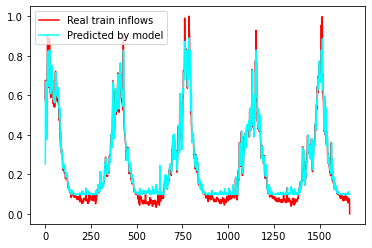

The rms loss in best configuration is 0.04435012632164786


In [0]:
#To see how the best configuration performs on the train data
svr = SVR(C= best_regularize, kernel = best_kernel)
svr = svr.fit(trainx,trainy)
predict_y = svr.predict(trainx)
plt.plot(trainy, color= 'red' , label = "Real train inflows")
plt.plot(predict_y , color = 'cyan' , label = "Predicted by model" )
plt.legend(loc = 'best')
plt.show()
test_rms = sqrt(mean_squared_error(trainy, predicted_train))
print("The rms loss in best configuration is", test_rms  )

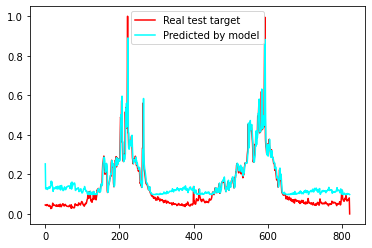

The rms loss in best configuration is 0.06387459597043925


In [0]:
#let us now try to preddict on the test data using the best configuration
svr = SVR(C= best_regularize, kernel = best_kernel)
svr = svr.fit(trainx,trainy)
predict_y = svr.predict(testx)
plt.plot(testy, color= 'red' , label = "Real test target")
plt.plot(predict_y , color = 'cyan' , label = "Predicted by model" )
plt.legend(loc = 'best')
plt.show()
test_rms = sqrt(mean_squared_error(testy, predict_y))
print("The rms loss in best configuration is", test_rms  )

SVMs model the flood peaks quite nicely but overestimate the inflows generally.
Also it we compare the results by the metric of the rms error values, we could say that the Recurrent neural networks (specifically here, LSTMs ) are superior in predicting the inflows, which is evident in the architecture of models, LSTMs are able to retain informaton longer and hence able to predice better.

Now let us try to use random forest regressor to check the input

<b> First let us check the various parameters which can be tuned :</b> 
<br>
<p>criterion : {“mse”, “friedman_mse”, “mae”}, default=”mse”
The function to measure the quality of a split. Supported criteria are “mse” for the mean squared error, which is equal to variance reduction as feature selection criterion and minimizes the L2 loss using the mean of each terminal node, “friedman_mse”, which uses mean squared error with Friedman’s improvement score for potential splits, and “mae” for the mean absolute error, which minimizes the L1 loss using the median of each terminal node.

<p> I had no reason to tweak this parameter as I am originally using the MSE error itself.

<p>splitter{“best”, “random”}, default=”best”
The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.
  Again, no change can be done here as well. 
<p>max_depthint, default=None
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
Limiting the depth will only hamper the regression quality, as the data is highly repetitive in nature.

<p>min_samples_leaf : int or float, default=1
The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This would have the effect of smoothning the model, thus not changed

<p>min_weight_fraction_leaffloat, default=0.0
The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided. No special features were present.

<p>max_features : int, float or {“auto”, “sqrt”, “log2”}, default=None
The number of features to consider when looking for the best split. Not applicable here as just the previous values is available.


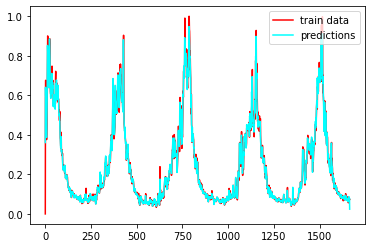

In [0]:
from sklearn.ensemble import RandomForestRegressor

#trainx trainy and testx testy are ready

regr = RandomForestRegressor(n_jobs = -1) # as described above.

regr.fit(trainx, trainy)
predicted = regr.predict(trainx)
plt.plot(trainx, color = 'red', label= 'train data')
plt.plot(predicted , color = 'cyan', label = 'predictions')
plt.legend(loc = 'best')
plt.show()

In [0]:
rms = sqrt(mean_squared_error(trainy, predicted))
print("The rms error given on training data by random forest regressor is ",rms)

The rms error given on training data by random forest regressor is  0.01751193089112603


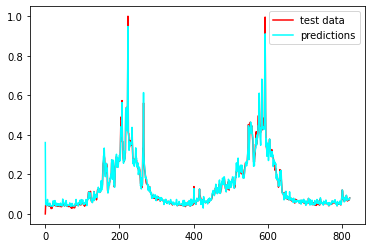

The rms error given on test data by random forest regressor is  0.04555089985082667


In [0]:
#now for predictions in test set 
predict = regr.predict(testx)
plt.plot(testx, color = 'red', label= 'test data')
plt.plot(predict , color = 'cyan', label = 'predictions')
plt.legend(loc = 'best')
plt.show()
rms = sqrt(mean_squared_error(testy, predict))
print("The rms error given on test data by random forest regressor is ",rms)

<b>Results and discussions : </b><br>Now, I have tested three different models which have varying settings, comparing the result on the whole, We can with surety and mathematical proof claim that LSTMs are better time series predictor. Here in table I provide the final test and train RMS errors in the models

Model Type | Train RMS error | Test RMS error
---- | ---- | ----
 Long Short Term Memory networks(RNNs) | 0.00149 | 0.00278 
Supprt Vector Regressor |0.0443 |0.06385 
Decision Tree Regressor |0.0175 |0.04555

We can, thus, use rank the specified models in the suitability to use for the predictions of inflow in the Bhakra dam which are of utmost importance. Although it is just a preliminery study, it can be extended to actually rival the convetional methods which are, for example the sequential method, linear addition method etc. This analysis can  be extremely helpful for dam planning and water distribution. 

<b>Summary </b>: <br>In this model, I have tried to apply the knowldege I have acquired in this course to my field of civil engineering. I found out that the "remembrance" propety of lstms is highly useful in inflow predictions as it is able to retain 10 days of information and since inflows are continuous, it is intuitively very understandable. The above results could be used in field by application of some factor of safety as is standard practive in engineering. Although it is generally assumed that the field of civil engineering is saturated with no means of further advances however, the advent of machine learning provides with a silver lining.